In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from simulation import *
import pickle as pkl
from matplotlib.lines import Line2D
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [2]:
## Plotting settings
from plotting_utils import plot_context
params, font = plot_context()
context = sns.plotting_context("paper", rc=params)
sns.set_theme(style="whitegrid", font=font)

In [3]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
    
def plot_conclusion(conclusion_list, metric, ax=None, pretty_name=None, plot_color=None, plot_time=None, plot_range=[20, 400]):
    if ax is None:
        fig, ax = plt.subplots()
    for c, time_range in conclusion_list:
        if plot_time is not None:
            if len(time_range) != 0 and (max(time_range)+1 not in plot_time):
                continue
        x = np.mean(c.avg_metrics['time'], 0)
        if metric == 'mediated_ph2_frac':
            avg_m , ci_m = c.mean_confidence_interval(c.avg_metrics['phase2_mediated'])
            avg_um, ci_um = c.mean_confidence_interval(c.avg_metrics['phase2_unmediated'])
            avg_m = np.array(avg_m)
            avg_um = np.array(avg_um)
            avg = avg_m / (avg_m + avg_um) * 100
            ci_m = np.array(ci_m)
            ci_um = np.array(ci_um)
        elif metric == 'ph2_bifrac':
            avg_m_mono = np.array(c.mean_confidence_interval(c.avg_metrics['phase2_mediated_mono'])[0])
            avg_m_bi = np.array(c.mean_confidence_interval(c.avg_metrics['phase2_mediated_bi'])[0])
            avg_um_mono = np.array(c.mean_confidence_interval(c.avg_metrics['phase2_unmediated_mono'])[0])
            avg_um_bi = np.array(c.mean_confidence_interval(c.avg_metrics['phase2_unmediated_bi'])[0])
            avg_m_bifrac = smooth(avg_m_bi / (avg_m_mono + avg_m_bi) * 100, 2)
            avg_um_bifrac = smooth(avg_um_bi / (avg_um_mono + avg_um_bi) * 100, 2)
        else:
            avg , ci = c.mean_confidence_interval(c.avg_metrics[metric])
            avg = np.array(avg)
            ci = np.array(ci)

        if len(time_range) == 0:
            label = 'Natural growth'
            color = 'black'
            lw = 3
            alpha = 1
        else:
            label = f'Intervention: t={min(time_range)}-{max(time_range)+1}'
            color = 'tab:blue' if plot_color is None else plot_color
            alpha = 0.1 + 0.9 * max(time_range)/plot_range[1]
            lw =2
        
        if metric == 'ph2_bifrac':
            ax.plot(x, avg_m_bifrac, color=color, linestyle='--', alpha=1, lw=lw)
            ax.plot(x, avg_um_bifrac, color=color, alpha=1, lw=lw)
        else:
            ax.plot(x, avg, label=label, color=color, alpha=alpha, lw=lw)
    ax.set_xlim(plot_range)
    ax.set(xlabel='Time', ylabel=metric if pretty_name is None else pretty_name)
    return ax

def plot_indirect(unmed_clist, med_clist, metric, ax=None, pretty_name=None, plot_color=None, plot_time=None, plot_range=[20, 400]):
    for i in range(len(med_clist)):
        c_m, time_range0 = med_clist[i]
        c_um, time_range1 = unmed_clist[i]
        if time_range0 != time_range1:
            return i
        if plot_time is not None:
            if len(time_range0) != 0 and (max(time_range0)+1 not in plot_time):
                continue
            
        x = np.mean(c_m.avg_metrics['time'], 0)

        avg_m = np.array(c_m.mean_confidence_interval(c_m.avg_metrics[metric])[0])
        avg_um = np.array(c_um.mean_confidence_interval(c_um.avg_metrics[metric])[0])
        if len(time_range0) == 0:
            label = 'Natural growth'
            color = 'black'
            lw = 3
            alpha = 1
            ax.plot(x, avg_m, label=label, color=color,alpha=alpha, lw=lw)

        else:
            label = f'Intervention: t={min(time_range0)}-{max(time_range0)+1}'
            color = 'tab:blue' if plot_color is None else plot_color
            alpha = 0.3 + 0.7 * max(time_range0)/plot_range[1]
            lw =2
            ax.plot(x, avg_m, label=label, color=color,alpha=alpha, lw=lw)
            ax.plot(x, avg_um, label=label, color=color, linestyle='--', alpha=alpha, lw=lw)
    
    ax.set_xlim(plot_range)
    ax.set(xlabel='Time', ylabel=metric if pretty_name is None else pretty_name)
    return ax

def plot_diff_frac(unmed_clist, med_clist, metric, nat_idx, ax=None, pretty_name=None, plot_color=None, smooth_pts=None, plot_time=None, plot_range=[20, 400]):
    c_nat = med_clist[nat_idx][0]
    for i in range(len(med_clist)):
        c_m, time_range0 = med_clist[i]
        c_um, time_range1 = unmed_clist[i]
        if time_range0 != time_range1:
            return i
        if len(time_range0) == 0 or (max(time_range0)+1 not in plot_time):
            continue
        
        x = np.mean(c_m.avg_metrics['time'], 0)

        avg_m = np.array(c_m.mean_confidence_interval(c_m.avg_metrics[metric])[0])
        avg_um = np.array(c_um.mean_confidence_interval(c_um.avg_metrics[metric])[0])
        avg_nat = np.array(c_nat.mean_confidence_interval(c_nat.avg_metrics[metric])[0])
        avg = (avg_m - avg_um) / (avg_m - avg_nat)
        if smooth_pts is not None:
            avg = smooth(avg, smooth_pts)
        avg = np.clip(avg, 0, None)
        avg[11:14] = 0
        label = f'Intervention: t={min(time_range0)}-{max(time_range0)+1}'
        color = 'tab:blue' if plot_color is None else plot_color
        alpha = 0.3 + 0.7 * max(time_range0)/plot_range[1]
        lw =2
        ax.plot(x, avg, label=label, color=color,alpha=alpha, lw=lw)
    ax.set_xlim(plot_range)
    ax.set(xlabel='Time', ylabel=metric if pretty_name is None else pretty_name)
    return ax


In [4]:
# load experiment results from exp_delayed_effects.py
rec_embedding_acc_constant = []
rec_embedding_acc_embedding = []
rec_fof_acc_constant = []
rec_fof_acc_embedding = []

onlyfiles = [f for f in listdir('experiments/exp_delayed_effects') if isfile(join('experiments/exp_delayed_effects', f))]
for f in onlyfiles:
    with open(join('experiments/exp_delayed_effects', f), 'rb') as f:
        rec_how, acc_how, intervention_end, conclusion = pkl.load(f)
        time_range = list(range(50, intervention_end))
        if rec_how == 'embedding':
            if acc_how == 'constant':
                rec_embedding_acc_constant.append((conclusion, time_range))
            if acc_how == 'embedding':
                rec_embedding_acc_embedding.append((conclusion, time_range))
        if rec_how == 'random_fof':
            if acc_how == 'constant':
                rec_fof_acc_constant.append((conclusion, time_range))
            if acc_how == 'embedding':
                rec_fof_acc_embedding.append((conclusion, time_range)) 

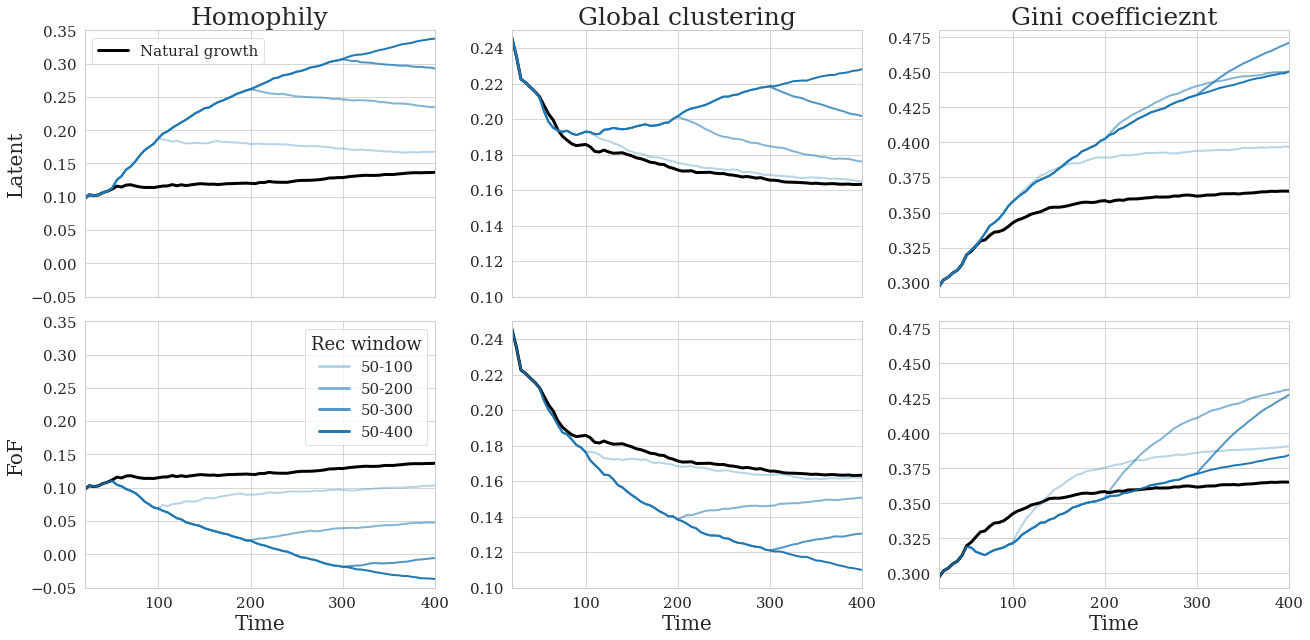

In [5]:
# plot graphs for delayed effects
with context:
    metrics = ['homophily_0', 'global_clustering', 'gini_coeff']
    pretty_names = ['Homophily', 'Global clustering', 'Gini coefficient']
    plot_time=[100, 200, 300, 400]
    fig, ax = plt.subplots(2, 3, figsize=(18, 9))

    for i, m in enumerate(metrics):
        plot_conclusion(rec_embedding_acc_constant, m, ax=ax[0, i], pretty_name=pretty_names[i], plot_time=plot_time)
        plot_conclusion(rec_fof_acc_constant, m, ax=ax[1, i], pretty_name=pretty_names[i], plot_time=plot_time)
        ax[0, i].set_xticklabels([])
        ax[0, i].set_xlabel('')
        # ax[i, 1].set_yticklabels([])
        ax[0, i].set_ylabel('')
        ax[1, i].set_ylabel('')
        
    ax[0 ,0].set_ylim([-0.05, 0.35])
    ax[1, 0].set_ylim([-0.05, 0.35])
    ax[0, 1].set_ylim([0.1, 0.25])
    ax[1, 1].set_ylim([0.1, 0.25])
    ax[0, 2].set_ylim([0.29, 0.48])
    ax[1, 2].set_ylim([0.29, 0.48])

    ax[0, 0].set_title('Homophily')
    ax[0, 1].set_title('Global clustering')
    ax[0, 2].set_title('Gini coefficieznt')
    ax[0, 0].set_ylabel('Latent')
    ax[1, 0].set_ylabel('FoF')
    
    lines = [Line2D([0], [0], color='black', linewidth=3)]
    labels = ['Natural growth']
    ax[0, 0].legend(lines, labels, loc='best')

    alpha = [0.1 + 0.9 * time_range0/400 for time_range0 in plot_time]

    lines = [Line2D([0], [0], color='tab:blue', linewidth=3, alpha=a) for a in alpha]
    labels = [f'50-{time_range0}' for time_range0 in plot_time]

    ax[1, 0].legend(lines, labels, loc='best', title='Rec window')
    plt.tight_layout()
    plt.show()

In [6]:
# load experiment results from exp_indirect_effects.py
only_unmediated =  [f for f in listdir('experiments/exp_indirect_effects') if isfile(join('experiments/exp_indirect_effects', f))]

unmed_rec_embedding_acc_constant = []
unmed_rec_embedding_acc_embedding = []
unmed_rec_fof_acc_constant = []
unmed_rec_fof_acc_embedding = []
for f in only_unmediated:
    with open(join('experiments/exp_indirect_effects', f), 'rb') as f:
        rec_how, acc_how, intervention_end, conclusion = pkl.load(f)
        time_range = list(range(50, intervention_end))
        if rec_how == 'embedding':
            if acc_how == 'constant':
                unmed_rec_embedding_acc_constant.append((conclusion, time_range))
            if acc_how == 'embedding':
                unmed_rec_embedding_acc_embedding.append((conclusion, time_range))
        if rec_how == 'random_fof':
            if acc_how == 'constant':
                unmed_rec_fof_acc_constant.append((conclusion, time_range))
            if acc_how == 'embedding':
                unmed_rec_fof_acc_embedding.append((conclusion, time_range)) 

<ipython-input-3-79ab3df2a74b>:19: RuntimeWarning: invalid value encountered in true_divide
  avg = avg_m / (avg_m + avg_um) * 100
<ipython-input-3-79ab3df2a74b>:27: RuntimeWarning: invalid value encountered in true_divide
  avg_m_bifrac = smooth(avg_m_bi / (avg_m_mono + avg_m_bi) * 100, 2)
<ipython-input-3-79ab3df2a74b>:28: RuntimeWarning: invalid value encountered in true_divide
  avg_um_bifrac = smooth(avg_um_bi / (avg_um_mono + avg_um_bi) * 100, 2)


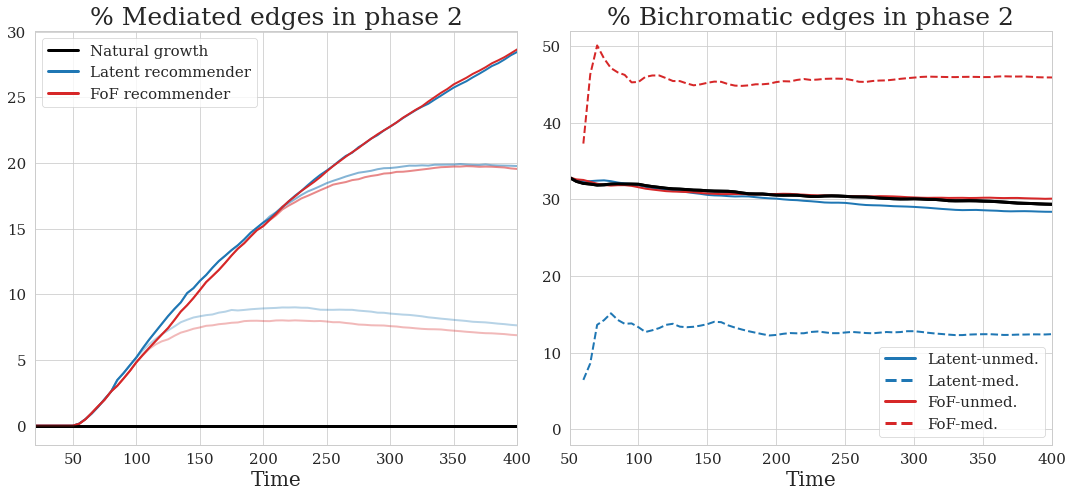

In [7]:
with context:
    metrics = ['mediated_ph2_frac', 'ph2_bifrac']
    pretty_names = ['Fraction of mediated edges in phase 2', 'Fraction of bi-chromatic edges in phase 2']
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    plot_conclusion(rec_embedding_acc_constant, 'mediated_ph2_frac', ax=ax[0], pretty_name='', plot_color='tab:blue', plot_time=[100, 200, 400])
    plot_conclusion(rec_fof_acc_constant, 'mediated_ph2_frac', ax=ax[0], pretty_name='', plot_color='tab:red', plot_time=[100, 200, 400])
    plot_conclusion(rec_embedding_acc_constant, 'ph2_bifrac', ax=ax[1], pretty_name='', plot_color='tab:blue', plot_time=[200])
    plot_conclusion(rec_fof_acc_constant, 'ph2_bifrac', ax=ax[1], pretty_name='', plot_color='tab:red', plot_time=[200])
    
    ax[1].set_xlim([50, 400])
    lines = [Line2D([0], [0], color='black', linewidth=3), Line2D([0], [0], color='tab:blue', linewidth=3), Line2D([0], [0], color='tab:red', linewidth=3), ]
    labels = ['Natural growth', 'Latent recommender', 'FoF recommender']

    ax[0].legend(lines, labels, loc='best')
    ax[0].set_title('% Mediated edges in phase 2')

    lines = [Line2D([0], [0], color='tab:blue', linewidth=3), Line2D([0], [0], color='tab:blue', linestyle='--', linewidth=3), Line2D([0], [0], color='tab:red', linewidth=3), Line2D([0], [0], color='tab:red', linestyle='--', linewidth=3),]
    labels = ['Latent-unmed.', 'Latent-med.', 'FoF-unmed.', 'FoF-med.']

    ax[1].legend(lines, labels, loc='lower right')
    ax[1].set_title('% Bichromatic edges in phase 2')
    ax[1].set_ylim([-2, 52])

    plt.tight_layout()
    plt.show()

<ipython-input-3-79ab3df2a74b>:103: RuntimeWarning: invalid value encountered in true_divide
  avg = (avg_m - avg_um) / (avg_m - avg_nat)


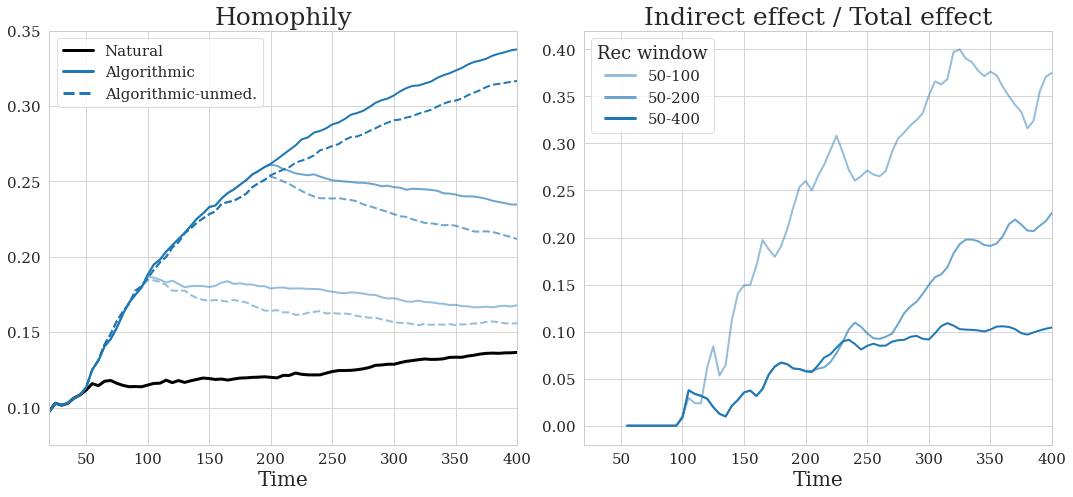

In [8]:
with context:
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    plot_time = [100, 200, 400]
    plot_indirect(unmed_rec_embedding_acc_constant, rec_embedding_acc_constant, 'homophily_0', ax=ax[0], plot_time=plot_time)
    ax[0].set_title('Homophily')

    plot_diff_frac(unmed_rec_embedding_acc_constant, rec_embedding_acc_constant, 'homophily_0', 1, ax=ax[1], smooth_pts=2, plot_time=plot_time)
    ax[1].set_title('Indirect effect / Total effect')

    lines = [Line2D([0], [0], color='black', linewidth=3), Line2D([0], [0], color='tab:blue', linewidth=3), Line2D([0], [0], color='tab:blue', linestyle='--', linewidth=3)]
    labels = ['Natural', 'Algorithmic', 'Algorithmic-unmed.']
    ax[0].legend(lines, labels, loc='best')
    alpha = [0.3 + 0.7 * time_range0/400 for time_range0 in plot_time]

    lines = [Line2D([0], [0], color='tab:blue', linewidth=3, alpha=alpha[0]), Line2D([0], [0], color='tab:blue', linewidth=3, alpha=alpha[1]), Line2D([0], [0], color='tab:blue', linewidth=3, alpha=alpha[2])]
    labels = [f'50-{time_range0}' for time_range0 in plot_time]
    ax[1].legend(lines, labels, loc='best', title='Rec window')

    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    plt.tight_layout()
    plt.show()


In [9]:
# load experiment results from exp_group_structure.py
group_exp = defaultdict(list)

settings = ['heterogeneity', 'homogeneity', 'minority_homophily', 'majority_heterophily']        
rec_how  = ['embedding', 'random_fof']
acc_how = ['constant']
intervention_end = list(range(50, 401, 100))
node_removal = [True, False]
edge_removal = [True, False]
p2_mediated = [True, False]

settings = list(product(settings, rec_how, acc_how, intervention_end, node_removal, edge_removal, p2_mediated))

for (grp, rec, acc, end, node, edge, med) in settings:
    with open(f'experiments/exp_group_effects/{grp}_{rec}_{acc}_{end}_{node}_{edge}_{med}.pkl', 'rb') as f:
        rec_how, acc_how, intervention_end, conclusion = pkl.load(f)
        time_range = list(range(50, intervention_end))
        group_exp[(grp, rec, acc, node, edge, med)].append((conclusion, time_range))

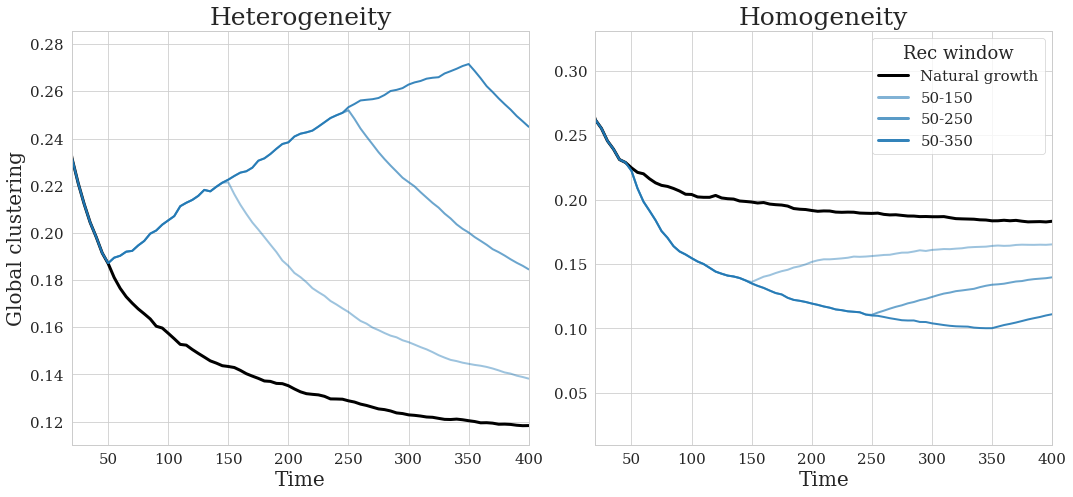

In [10]:
with context:
    plot_time = [150, 250, 350]

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    plot_conclusion(group_exp[('heterogeneity', 'embedding', 'constant', False, False, True)], 'global_clustering', ax=ax[0], pretty_name='Global clustering', plot_time=plot_time)

    plot_conclusion(group_exp[('homogeneity', 'embedding', 'constant', False, False, True)], 'global_clustering', ax=ax[1], pretty_name='', plot_time=plot_time)

    ax[0].set_title('Heterogeneity')
    ax[1].set_title('Homogeneity')

    alpha = [0.3 + 0.7 * time_range0/400 for time_range0 in [150, 250, 350]]
    lines = [Line2D([0], [0], color='black', linewidth=3), Line2D([0], [0], color='tab:blue', linewidth=3, alpha=alpha[0]), Line2D([0], [0], color='tab:blue', linewidth=3, alpha=alpha[1]), Line2D([0], [0], color='tab:blue', linewidth=3, alpha=alpha[2])]
    labels = ['Natural growth']
    labels.extend([f'50-{time_range0}' for time_range0 in [150, 250, 350]])

    ax[1].legend(lines, labels, loc='best', title='Rec window')
    plt.tight_layout()
    plt.show()

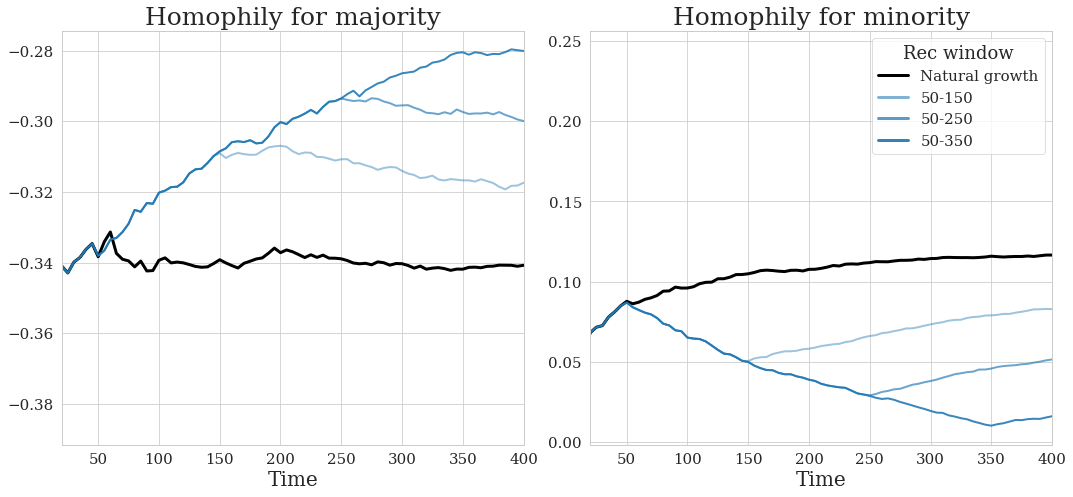

In [11]:
with context:
    metrics = ['homophily_0', 'homophily_1']
    pretty_names = ['Homophily for majority', 'Homophily for minority']
    plot_time = [150, 250, 350]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    plot_conclusion(group_exp[('majority_heterophily', 'random_fof', 'constant', False, False, True)], metrics[0], ax=ax[0], pretty_name=pretty_names[0], plot_time=plot_time)

    plot_conclusion(group_exp[('majority_heterophily', 'random_fof', 'constant', False, False, True)], metrics[1], ax=ax[1], pretty_name=pretty_names[1], plot_time=plot_time)

    ax[0].set_title('Homophily for majority')
    ax[1].set_title('Homophily for minority')
    ax[1].set_ylabel('')
    ax[0].set_ylabel('')

    alpha = [0.3 + 0.7 * time_range0/400 for time_range0 in [150, 250, 350]]
    lines = [Line2D([0], [0], color='black', linewidth=3), Line2D([0], [0], color='tab:blue', linewidth=3, alpha=alpha[0]), Line2D([0], [0], color='tab:blue', linewidth=3, alpha=alpha[1]), Line2D([0], [0], color='tab:blue', linewidth=3, alpha=alpha[2])]
    labels = ['Natural growth']
    labels.extend([f'50-{time_range0}' for time_range0 in [150, 250, 350]])

    ax[1].legend(lines, labels, loc='best', title='Rec window')
    plt.tight_layout()
    plt.show()